In [1]:
from tqdm import tqdm
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
import cobra
config = cobra.Configuration()
config.processes = 1

In [3]:
import cobra.io
import gzip

with gzip.open('iJN1463.json.gz') as file:
    model = cobra.io.load_json_model(file)
    
INF = 999999.0

In [4]:
# This gene is inactive in putida, doi:10.1111/1462-2920.13230
model.reactions.PPCK.knock_out()

In [5]:
# Add AroG-D146N gene
model.genes.add(cobra.Gene(id='AroG_D146N', name='AroG-D146N'))
model.reactions.DDPA.gene_reaction_rule = model.reactions.DDPA.gene_reaction_rule + ' or AroG_D146N'

In [6]:
asbf = cobra.Reaction(id='ASBF', name='3-dehydroshikimate dehydratase')

asbf.add_metabolites({
    model.metabolites.get_by_id("3dhsk_c"): -1,
    model.metabolites.get_by_id("34dhbz_c"): 1,
    model.metabolites.get_by_id("h2o_c"): 1})

model.add_reaction(asbf)

model.genes.add(cobra.Gene(id='AsbF', name='AsbF'))
model.genes.add(cobra.Gene(id='B3ZVR2_BACCE', name='B3ZVR2_BACCE'))

asbf.gene_reaction_rule = 'AsbF or B3ZVR2_BACCE'


aroy = cobra.Reaction(id='AROY', name='protocatechuate decarboxylase')

aroy.add_metabolites({
    model.metabolites.get_by_id("34dhbz_c"): -1,
    model.metabolites.get_by_id("catechol_c"): 1,
    model.metabolites.get_by_id("h_c"): -1,    
    model.metabolites.get_by_id("co2_c"): 1})

model.add_reaction(aroy)

In [7]:
model.reactions.SUCCt2_2pp.bounds = (-INF, INF)
model.reactions.OCDCAtexi.bounds = (-INF, INF)
model.reactions.OCDCEAtexi.bounds = (-INF, INF)
model.reactions.HDCAtexi.bounds = (-INF, INF)

In [8]:
for met_id in ['ccmuac_c', 'arab__L_c', 'udpgal_c',
               '6pgl_c', 'acon_T_c', 's7p_c']:
    
    met = model.metabolites.get_by_id(met_id)
    ext_met = met.copy()
    ext_met.id = met_id[:-2] + '_e'
    ext_met.compartment = 'e'
    
    model.add_metabolites([ext_met])
    
    try:
        model.metabolites.get_by_id(f'{met_id[:-2]}_p')
    except KeyError:
        trxn = cobra.Reaction(met_id[:-2] + '_transport')
        model.add_reaction(trxn)
        trxn.reaction = f'{met_id} <=> {ext_met.id}'
    
    boundary = model.add_boundary(ext_met)
    boundary.bounds = (0, INF)

In [9]:
model.summary()

In [10]:
with model:
    model.objective = model.reactions.EX_ccmuac_e
    print(model.summary())

IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES  OBJECTIVES  OBJECTIVES
    ID       FLUX       ID        FLUX         ID         FLUX   
     o2_e     10        h2o_e     21.8     EX_ccmuac_e    4.73   
 glc__D_e      6          h_e     9.45                     nan   
             nan        co2_e     7.65                     nan   
             nan     ccmuac_e     4.73                     nan   


cobra/core/summary/summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


In [11]:
import pandas as pd
import numpy as np
boundary_data = pd.read_csv('boundary_flux_from_external_measurements.csv')

In [12]:
result = model.optimize()

In [13]:
# Run FVA on an example row to get values for external metabolite flux
ref_row = boundary_data.iloc[85]

with model:

    model.reactions.EX_glc__D_e.lower_bound = -ref_row.glucose_uptake
    model.reactions.EX_glcn_e.lower_bound = -ref_row.gluconate_uptake
    model.reactions.EX_fru_e.lower_bound = -ref_row.fructose_uptake

    model.reactions.EX_ccmuac_e.lower_bound = ref_row.muconate_production
    model.reactions.EX_2dhglcn_e.lower_bound = ref_row['2-ketogluconate_production']
    
    max_gr = model.slim_optimize()
    
    fva_results = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.90)

# Metabolites present in external media
other_mets = ['34dhbz_e', '6pgl_e', 
              'acon_T_e', 's7p_e', 'glyc_e', 'glyclt_e', 
              'lac__D_e', 'pyr_e', 'succ_e', 'ocdca_e', 'hdca_e']

external_bounds = 0.1 * fva_results.loc['EX_' + pd.Series(other_mets)]['maximum']

In [14]:
from cobra.flux_analysis import pfba

def calc_gr(row, model=model):
    
    with model:
        model.reactions.EX_glc__D_e.lower_bound = -row.glucose_uptake
        model.reactions.EX_glcn_e.lower_bound = -row.gluconate_uptake
        model.reactions.EX_fru_e.lower_bound = -row.fructose_uptake

        model.reactions.EX_ccmuac_e.lower_bound = row.muconate_production
        model.reactions.EX_2dhglcn_e.lower_bound = row['2-ketogluconate_production']
        
        for rxnid, flux in external_bounds.iteritems():
            model.reactions.get_by_id(rxnid).lower_bound = flux

        try:
            result = pfba(model)
        except cobra.exceptions.Infeasible:            
            model.reactions.EX_2dhglcn_e.lower_bound = 0
            model.reactions.BIOMASS_KT2440_WT3.lower_bound = row.growth_rate
            model.objective = model.reactions.EX_2dhglcn_e
            try:
                result = pfba(model)
            except cobra.exceptions.Infeasible:  
                return None
                
        return result.fluxes

In [15]:
fluxes = boundary_data.progress_apply(calc_gr, axis=1)

100%|██████████| 88/88 [00:57<00:00,  1.54it/s]


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

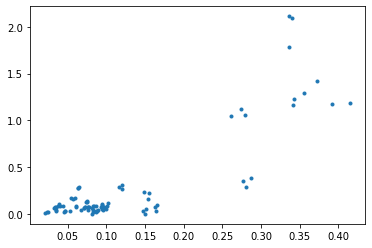

In [17]:
# At least they're correlated...
plt.plot(boundary_data.growth_rate, fluxes['BIOMASS_KT2440_WT3'], '.')

In [35]:
reduced_model = model.copy()

for rxn in tqdm(fluxes.columns[np.isclose(fluxes.fillna(0.), 0).all(0)]):
    reduced_model.reactions.get_by_id(rxn).remove_from_model()

for met in tqdm(reduced_model.metabolites.query(lambda x: len(x.reactions) < 2)):
    met.remove_from_model()

100%|██████████| 1493/1493 [00:00<00:00, 2368.45it/s]


100%|██████████| 88/88 [00:08<00:00, 10.10it/s]


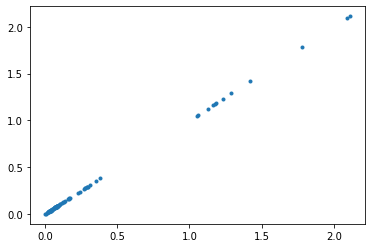

In [36]:
fluxes_reduced = boundary_data.progress_apply(calc_gr, axis=1, model=reduced_model).fillna(0.)

plt.plot(fluxes['BIOMASS_KT2440_WT3'], fluxes_reduced['BIOMASS_KT2440_WT3'], '.')

In [37]:
for rxn in tqdm(fluxes_reduced.columns[np.isclose(fluxes_reduced.fillna(0.), 0).all(0)]):
    reduced_model.reactions.get_by_id(rxn).remove_from_model()

for met in tqdm(reduced_model.metabolites.query(lambda x: len(x.reactions) < 2)):
    met.remove_from_model()

100%|██████████| 1/1 [00:00<00:00, 1390.22it/s]


In [38]:
ref_row = boundary_data.iloc[85]

with reduced_model:

    reduced_model.reactions.EX_glc__D_e.lower_bound = -ref_row.glucose_uptake
    reduced_model.reactions.EX_glcn_e.lower_bound = -ref_row.gluconate_uptake
    reduced_model.reactions.EX_fru_e.lower_bound = -ref_row.fructose_uptake

    reduced_model.reactions.EX_ccmuac_e.lower_bound = ref_row.muconate_production
    reduced_model.reactions.EX_2dhglcn_e.lower_bound = ref_row['2-ketogluconate_production']
    
    for rxnid, flux in external_bounds.iteritems():
        reduced_model.reactions.get_by_id(rxnid).lower_bound = flux
        
    fva_results = cobra.flux_analysis.flux_variability_analysis(reduced_model, fraction_of_optimum=0.90)
    
    
#     max_gr = model.slim_optimize()
    
#     fva_results = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.90)

In [52]:
tol = 1E-7

with reduced_model:
        
    reduced_model.reactions.EX_glc__D_e.lower_bound = -ref_row.glucose_uptake
    reduced_model.reactions.EX_glcn_e.lower_bound = -ref_row.gluconate_uptake
    reduced_model.reactions.EX_fru_e.lower_bound = -ref_row.fructose_uptake

    reduced_model.reactions.EX_ccmuac_e.lower_bound = ref_row.muconate_production
    reduced_model.reactions.EX_2dhglcn_e.lower_bound = ref_row['2-ketogluconate_production']
    
    for rxnid, flux in external_bounds.iteritems():
        reduced_model.reactions.get_by_id(rxnid).lower_bound = flux
        
    print(reduced_model.summary())
    
    
    while True:
        result = reduced_model.optimize()
        assert result.status == 'optimal'
        if (result.fluxes == 0).sum() == 0: 
            break
        rxn = result.fluxes[result.fluxes.abs() < tol].index[0]
        fva_result = cobra.flux_analysis.flux_variability_analysis(reduced_model, reaction_list=[rxn], fraction_of_optimum=.9).iloc[0]
        print(f"{rxn}: {fva_result['minimum']}, {fva_result['maximum']}")
        
        if fva_result.abs().max() > (tol * 10):
            if fva_result['maximum'] > abs(fva_result['minimum']):
                reduced_model.reactions.get_by_id(rxn).lower_bound = fva_result['maximum'] * 0.1
            else:
                reduced_model.reactions.get_by_id(rxn).upper_bound = fva_result['minimum'] * 0.1   
            
        else:
            reduced_model.reactions.get_by_id(rxn).remove_from_model()
            print(f'removing {rxn}')

cobra/core/summary/summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


IN_FLUXES IN_FLUXES OUT_FLUXES OUT_FLUXES      OBJECTIVES     OBJECTIVES
    ID       FLUX       ID        FLUX             ID            FLUX   
     o2_e     2.15       h2o_e    5.72     BIOMASS_KT2440_WT3   0.0618  
   glcn_e     1.77   2dhglcn_e    1.52                             nan  
    nh4_e    0.658       co2_e    1.42                             nan  
    fru_e    0.604         h_e    1.19                             nan  
 glc__D_e    0.234    ccmuac_e   0.361                             nan  
     pi_e   0.0694                 nan                             nan  
2AACLPPEAT160: 0.0, 0.016938365010618652
2AACLPPEAT180: 0.0, 0.014977519815005268
2AACLPGT160: 0.0, 0.01524452850956315
2AACLPGT180: 0.0, 0.013346468828115035
AROH: 0.0, 0.011577131045026954
ASPO3: 0.0, 0.00013792831927964314
ASPO5: 0.0, 0.00012413548735150498
CU2tonex: 0.0, 5.35900352539865
CYSTGL: 0.0, 0.0036000578730226817
CYTBDpp: 0.0, 2.6526527442042074
DHMPTRx: 0.0, 1.3244866880196502e-05
DHMPTR: 0.0, 1.192

100%|██████████| 88/88 [00:08<00:00, 10.48it/s]


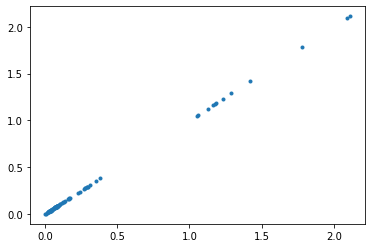

In [53]:
fluxes_reduced = boundary_data.progress_apply(calc_gr, axis=1, model=reduced_model).fillna(0.)
plt.plot(fluxes['BIOMASS_KT2440_WT3'], fluxes_reduced['BIOMASS_KT2440_WT3'], '.')

In [54]:
fluxes_reduced.isna().any(1).sum()

0

In [55]:
result.fluxes.abs().min()

9.535367680179189e-07

In [57]:
result.fluxes.to_csv('reference_fluxes_GB032gfg.csv')

In [59]:
cobra.io.save_json_model(reduced_model, 'reduced_iJN1463.json')

In [63]:
N = cobra.util.create_stoichiometric_matrix(reduced_model)
v_star = result.fluxes.values.flatten()

N_corr = N @ np.diag((v_star > 0) * 2 - 1)

In [65]:
N_corr.shape

(665, 716)

In [66]:
len(reduced_model.reactions)

716

In [71]:
N_bool = (N != 0)

In [72]:
N_bool.sum(1)

array([  4,   2,   2,   3,   2,   2,   3,   2,   4,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         3,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   3,   2,   2,   2,   2,   2,   3,
         2,   2,   2,   3,   2,   2,   2,   2,   4,   2,   2,   2,   3,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   3,   2,
         3,   2,   2,   2,   2,   2,   2,   3,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   4,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   3,   2,   3,   2,   2,   2,
         2,   2,   2,   2,   3,   2,   6,   3,   2,  14,   2,   2,   2,
         2,   2,   3,   4,   3,   2,   2,  34,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2, 105,   2,   3,   4,   8,   2,
         8,   3,  13,   2,   3,   4,   4,   3,  18,   2,   2, 124,   2,
         3,   2,   5,  17,   2,  19,   2,   5,   2,   2,   2,   